# ResNet18 implementation

ResNet paper:
https://arxiv.org/pdf/1512.03385.pdf

The implementation details of ResNet18 are listed in Table 1 of the paper.



In [ ]:
import torch
import torch.nn as nn


class ResNetBlock(nn.Module):
    """
    The ResNet block is a building block for the ResNet18 model. It consists of 2 convolutional layers and a shortcut connection.
    """

    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes a ResNet block by defining the 2 convolutional layers and the shortcut connection.

        Args:
            in_channels: The number of input channels.
            out_channels: The number of output channels.
            stride: The stride of the first convolutional layer.
        """
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )


    def forward(self, x):
        """
        Performs a forward pass through the ResNet block.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet18(nn.Module):
    """
    The ResNet18 model is a convolutional neural network that consists of 4 layers, each containing a number of ResNet blocks.
    """

    def __init__(self, num_classes=400):
        """
        Initializes the ResNet18 convoluted neural network by constructing the
        appropriate structure.

        Args:
            num_classes: The number of classes in the dataset.
        """
        super(ResNet18, self).__init__()

        self.in_channels = 64
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(ResNetBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResNetBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResNetBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResNetBlock, 512, 2, stride=2)
        #self.linear = nn.Linear(512, num_classes)
        self.linear = nn.Linear(4608, num_classes)

    def forward(self, x):
        """
        Performs a forward pass through the ResNet18 model.

        Args:
            x: The input tensor.

        Returns:
            The output tensor.
        """
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Creates a layer of ResNet blocks.

        Args:
            in_channels: number of input channels
            out_channels: number of output channels
            num_blocks: number of ResNet blocks in the layer
            stride: stride of the first convolutional layer

        Returns:
            a layer of ResNet blocks
        """
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)


Networks in PyTorch can be defined as in the example below:

In [ ]:
class ExampleNet(nn.Module):
    def __init__(self):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.fc_out = nn.Linear(128,400)

    def forward(self, x):
        c1 = self.conv1(x)
        bn1 = self.batchnorm1(c1)
        a1 = nn.functional.relu(bn1)
        p1 = self.pool1(a1)

        c2 = self.conv2(p1)
        bn2 = self.batchnorm2(c2)
        a2 = nn.functional.relu(bn2)
        p2 = self.pool2(a2)

        c3 = self.conv3(p2)
        bn3 = self.batchnorm3(c3)
        a3 = nn.functional.relu(bn3)
        p3 = self.pool3(a3)

        c4 = self.conv4(p3)
        bn4 = self.batchnorm4(c4)
        a4 = nn.functional.relu(bn4)
        # Take the global averag0.001e of each channel
        global_avg = torch.mean(a4, dim=[2,3])
        out = self.fc_out(global_avg)
        return out

# Loading the data

We will use a bird dataset, where the task is to classify each image into one of 400 different classes of birds.

## Download the data

In [ ]:
!pip install --upgrade --no-cache-dir gdown
#!gdown  --id 1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1
# if this link does not work use the commented one above
!gdown  --id 1XyR7UUHaM5CgJBOdcje-UI8uEMBPP9ZU
!unzip -q bird_data.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1XyR7UUHaM5CgJBOdcje-UI8uEMBPP9ZU

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open bird_data.zip, bird_data.zip.zip or bird_data.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install --upgrade --no-cache-dir gdown
!unzip -q /content/gdrive/MyDrive/bird_data/bird_data.zip -d .

## Data Loader

* PyTorch typically uses Dataset and DataLoader classes to load data during training. The DataLoader enables processing data on multiple cores (num_workers argument), which is useful as the data loading speed is commonly the bottleneck in network training.

* The batch size used during training is also usually an argument of the DataLoader.

* We will be using the torchvision.datasets.ImageFolder class that can easily load images that have been separated into individual folders by class. The data loader then outputs the data in the form of (image, label) pairs. For tasks other than classification, custom dataset classes are more common.

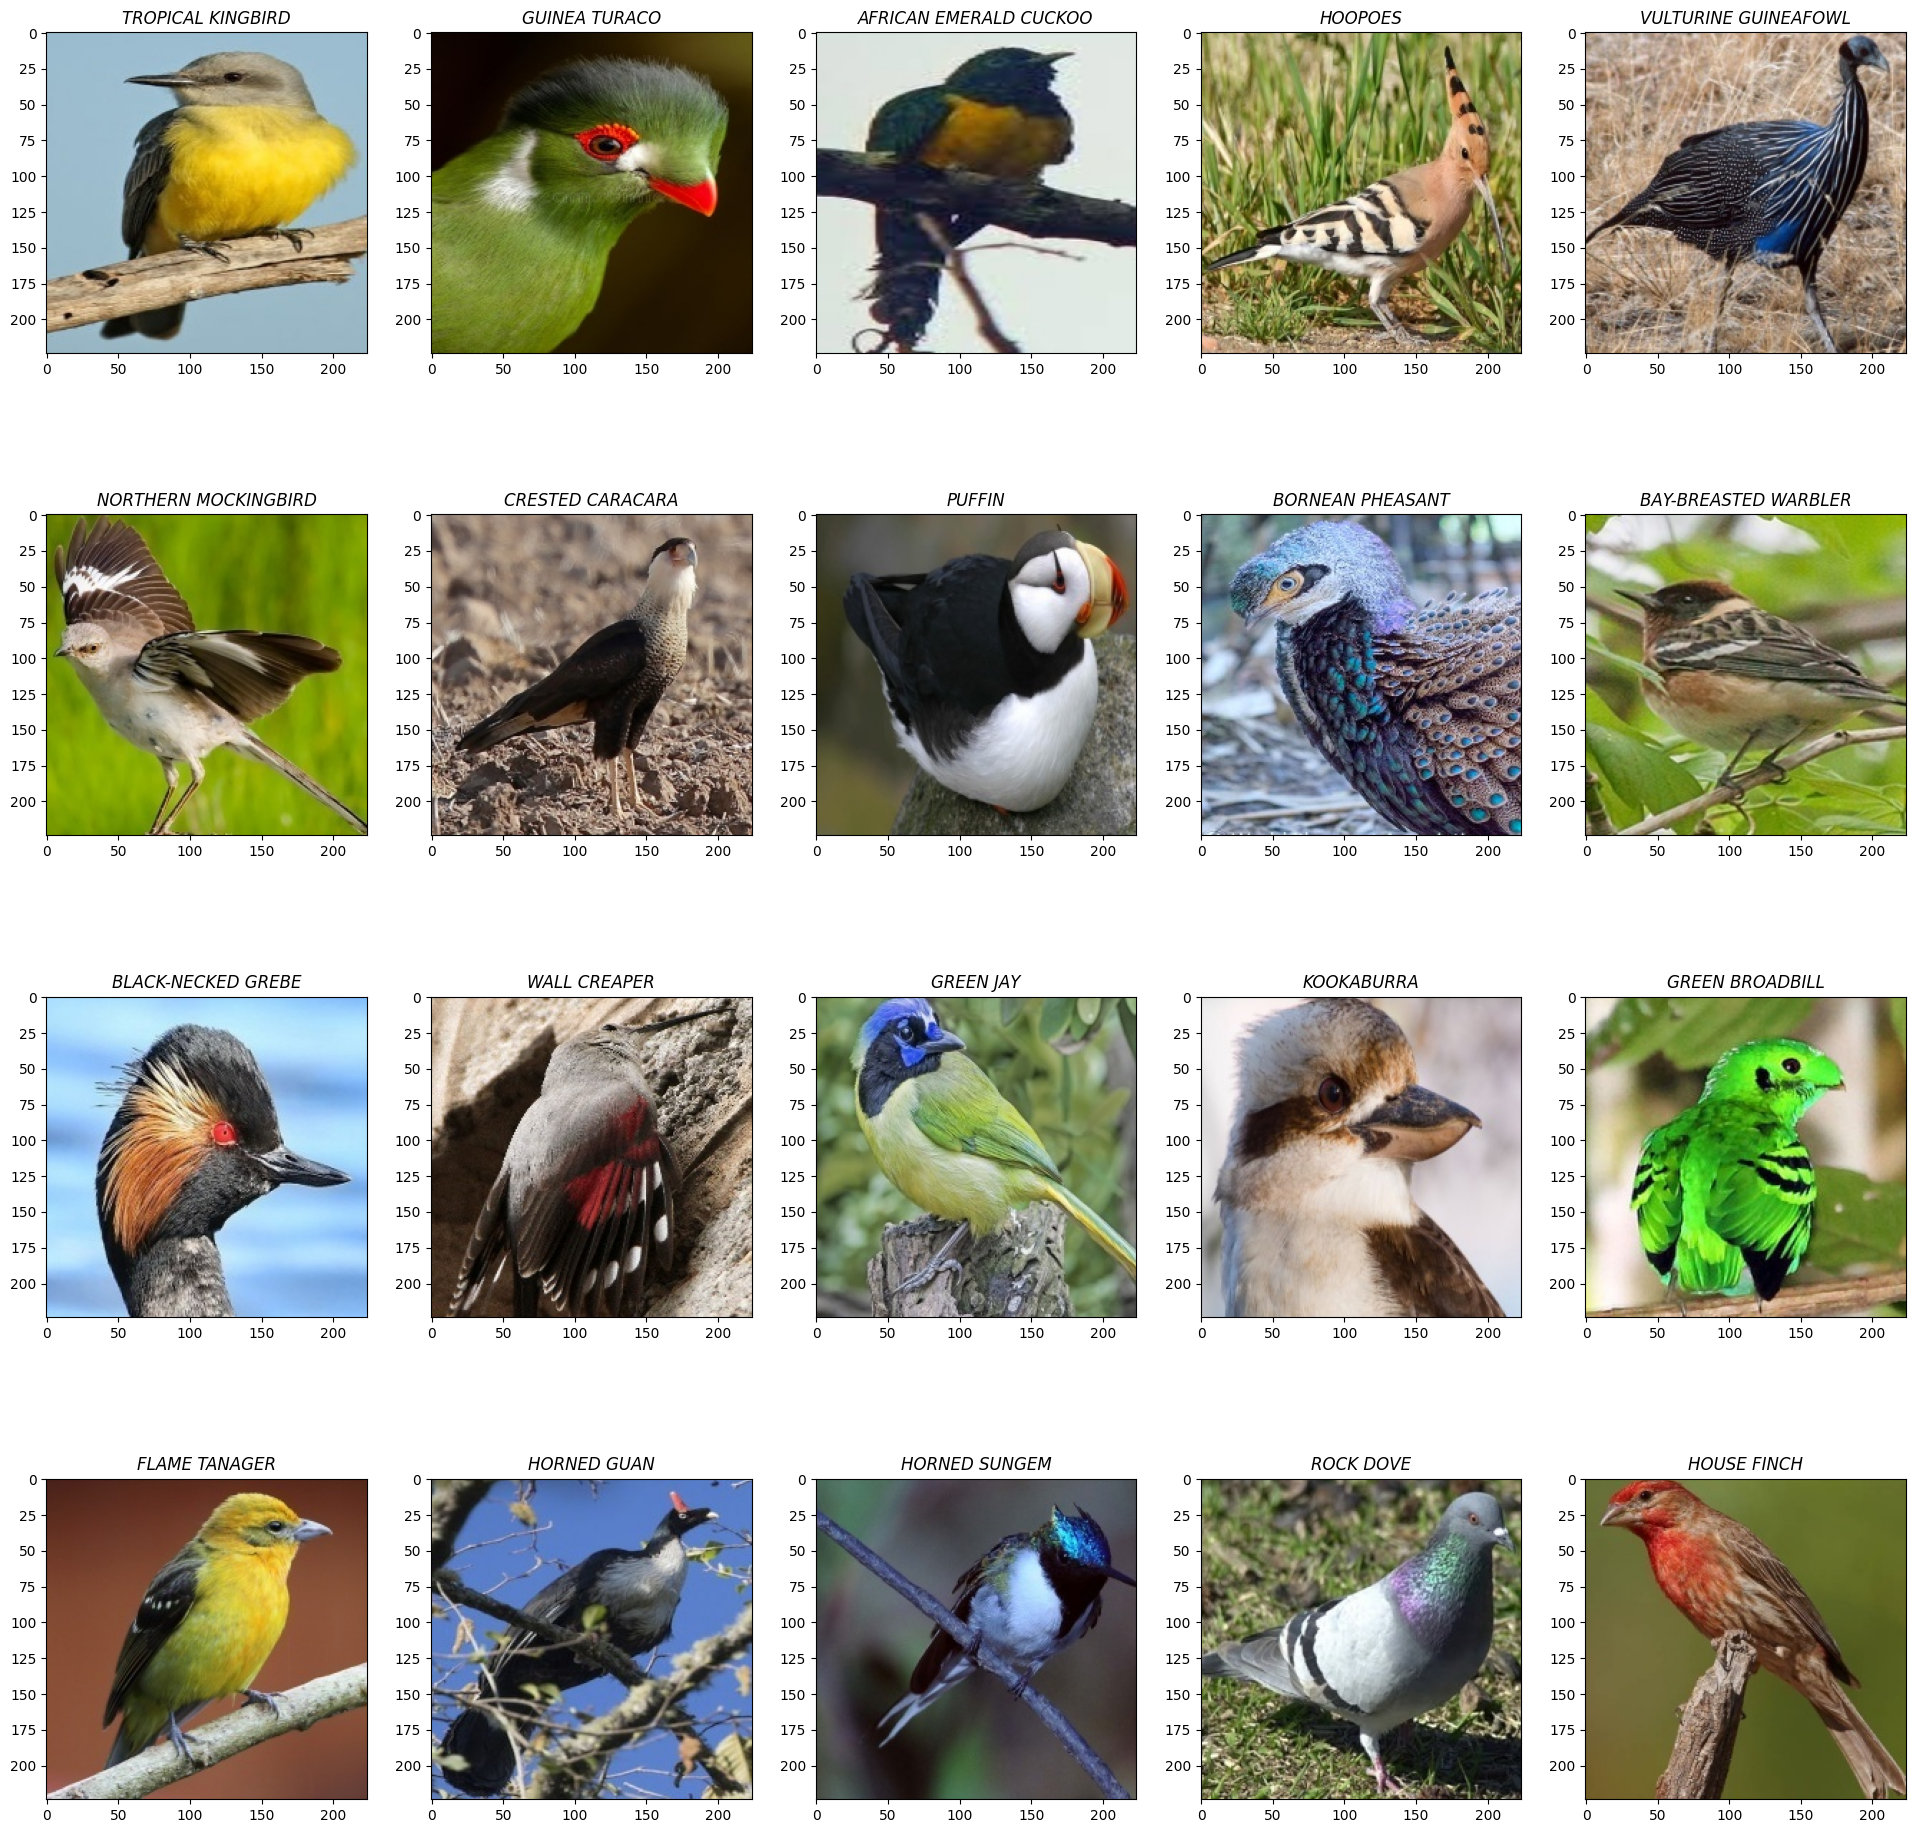

In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms

batch_size = 32
# Transforms can also be used for image augmentation - https://pytorch.org/vision/stable/transforms.html
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    ])


trainset = torchvision.datasets.ImageFolder(root='./bird_data/train/',transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./bird_data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root='./bird_data/valid/',transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


# Displaying random trainset images
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(columns*rows):
  input, label = trainset[np.random.randint(len(trainset))]
  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title(trainset.classes[label], fontstyle='italic')
  plt.imshow(img)
plt.show()



## Training the network

The training parameters (learning rate, batch size, optimizer choice etc.) are not fine-tuned. Feel free to optimize the parameters further to improve the results.

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def test_bird_model(net, curr_data_loader, val_test="val"):
    # Testing

    criterion = nn.CrossEntropyLoss()

    num_images = len(curr_data_loader.dataset)
    gt_array = np.zeros(num_images)
    pred_array = np.zeros(num_images)

    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(curr_data_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            gt_array[i*labels.size(0):(i+1)*labels.size(0)] = labels.detach().cpu().numpy()
            pred_array[i*labels.size(0):(i+1)*labels.size(0)] = predicted.detach().cpu().numpy()

    print('Accuracy of the network on %s images: %d %%' % (val_test,
            100 * correct / total))
    print("Test loss: "+str(running_loss/(total/4)))
    return gt_array, pred_array

def train_bird_model(epochs, lr):
    # Use the ResNet18 when implemented
    net = ResNet18()
    # net = ExampleNet()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # Define the learning rate scheduler
    lambda1 = lambda epoch: 1 - epoch / epochs
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    for epoch in range(epochs):
        with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # Get the inputs; Data is a tuple of (images, labels)
                inputs, labels = data
                # Transfer the images and labels to the GPU.
                inputs = inputs.cuda()
                labels = labels.cuda()

                # Clear the saved gradients of the previous iteration
                optimizer.zero_grad()

                outputs = net(inputs)
                # Calculate the loss value
                loss = criterion(outputs, labels)
                # Calculate the gradients using backpropagation
                loss.backward()
                # Update the weights of the network using the chosen optimizer
                optimizer.step()

                prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
                prog_bar.update(batch_size)

        scheduler.step()

        if epoch % 5 == 0:
            net.eval()
            test_bird_model(net, valloader)
            net.train()

    net.eval()
    test_bird_model(net,testloader)

    return net




## Run training

In [ ]:
net = train_bird_model(20, 0.001)

Epoch: 0/20: 58400img [04:23, 221.86img/s, loss=2.8904788]                          


Accuracy of the network on val images: 33 %
Test loss: 0.39639231300354005


Epoch: 1/20: 58400img [04:21, 223.58img/s, loss=1.9023482]                          
Epoch: 2/20: 58400img [04:21, 223.52img/s, loss=0.9991728]
Epoch: 3/20: 58400img [04:27, 218.22img/s, loss=0.7813835]
Epoch: 4/20: 58400img [04:24, 220.76img/s, loss=0.06832178]                          
Epoch: 5/20: 58400img [04:24, 221.19img/s, loss=0.13987008]                          


Accuracy of the network on val images: 82 %
Test loss: 0.0986418927013874


Epoch: 6/20: 58400img [04:24, 221.16img/s, loss=0.13836986]
Epoch: 7/20: 58400img [04:24, 221.06img/s, loss=0.049267076]                          
Epoch: 8/20: 58400img [04:24, 220.91img/s, loss=0.017305834]
Epoch: 9/20: 58400img [04:23, 221.59img/s, loss=0.018586928]                          
Epoch: 10/20: 58400img [04:24, 220.92img/s, loss=0.017367262]                          


Accuracy of the network on val images: 84 %
Test loss: 0.10414970608055592


Epoch: 11/20: 58400img [04:23, 221.42img/s, loss=0.024651384]
Epoch: 12/20: 58400img [04:21, 223.32img/s, loss=0.051713668]                          
Epoch: 13/20: 58400img [04:21, 223.57img/s, loss=0.004874896]
Epoch: 14/20: 58400img [04:20, 224.44img/s, loss=0.029054195]                          
Epoch: 15/20: 58400img [04:21, 223.52img/s, loss=0.0013800304]                          


Accuracy of the network on val images: 86 %
Test loss: 0.09565705940872431


Epoch: 16/20: 58400img [04:21, 223.62img/s, loss=0.002289401]                          
Epoch: 17/20: 58400img [04:20, 224.05img/s, loss=0.0015481375]                          
Epoch: 18/20: 58400img [04:20, 224.57img/s, loss=0.00023068432]
Epoch: 19/20: 58400img [04:22, 222.82img/s, loss=0.0004064307]


Accuracy of the network on val images: 90 %
Test loss: 0.06562150722416117


## Run Test and visualize classification errors



Accuracy of the network on val images: 90 %
Test loss: 0.06562150722416117


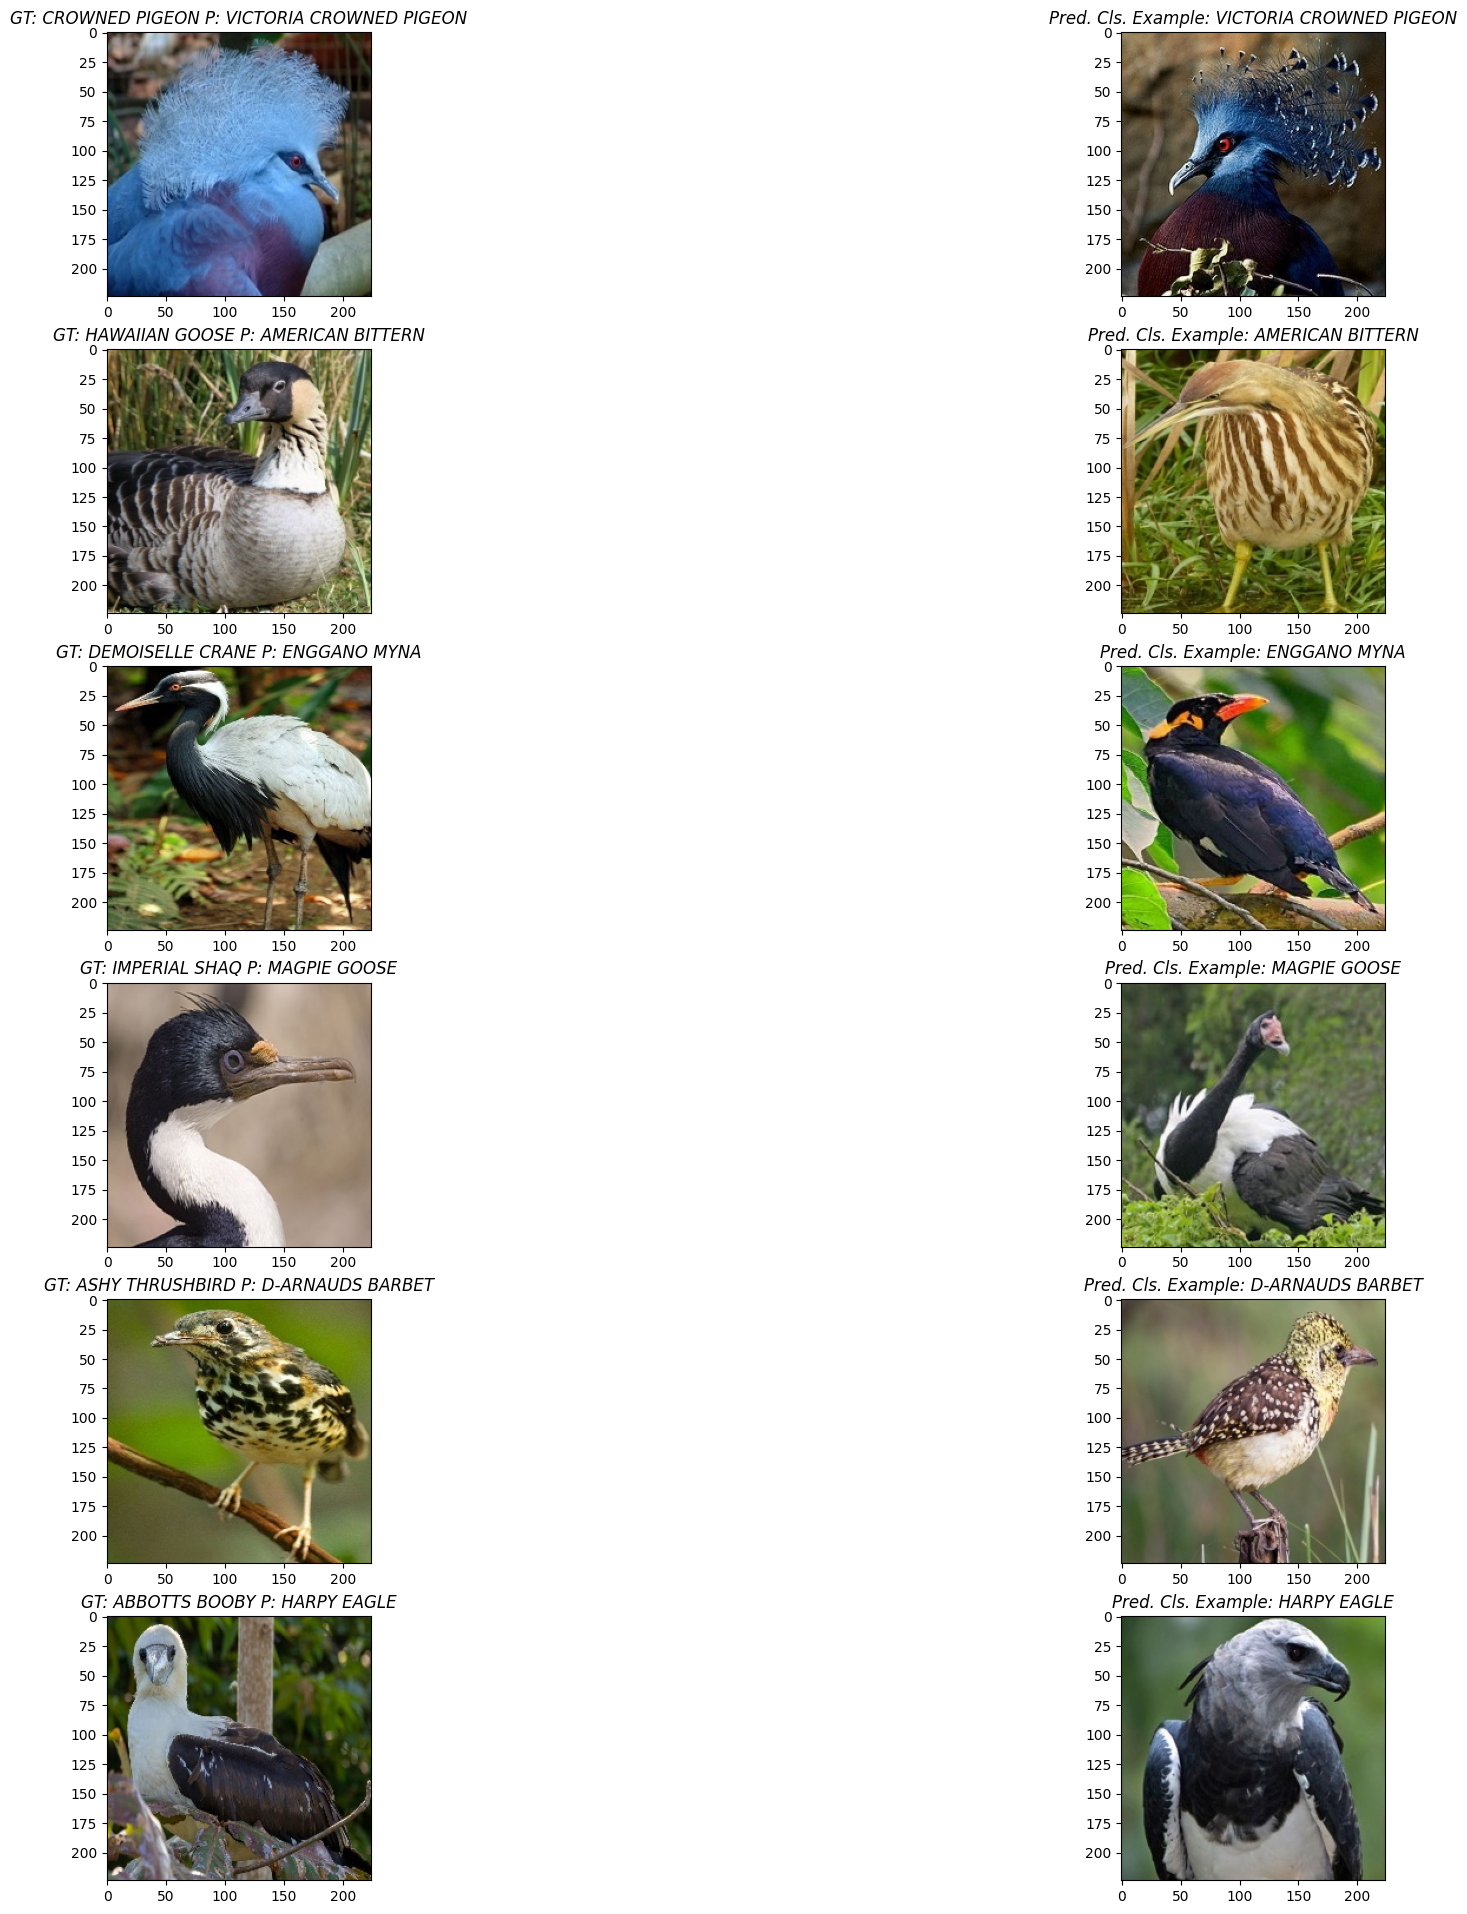

In [ ]:
gt_array, pred_array = test_bird_model(net,testloader)

# Displaying random misclassified images
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 6
mistake_indices = np.nonzero(gt_array != pred_array)[0]
for i in range(rows):
  chosen_index = mistake_indices[np.random.randint(len(mistake_indices))]
  input, label = testset[chosen_index]
  pred_label = pred_array[chosen_index].astype(np.int32)
  pred_cls_samples = np.nonzero(gt_array == pred_label)[0]
  pred_cls_input, _ = testset[pred_cls_samples[np.random.randint(len(pred_cls_samples))]]


  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+1)
  im_title = "GT: "+trainset.classes[label] + " P: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img)

  img_sample = pred_cls_input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+2)
  im_title = "Pred. Cls. Example: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.imshow(img_sample)

plt.show()
